## Table of Contents

### 1. Data Loading and Preprocessing 
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Segmentation using Pretrained Mask R-CNN
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# get images
!unzip /content/drive/My\ Drive/images_BloodCellSegmentation.zip

Archive:  /content/drive/My Drive/images_BloodCellSegmentation.zip
  inflating: images_BloodCellSegmentation/001.bmp  
  inflating: images_BloodCellSegmentation/002.bmp  
  inflating: images_BloodCellSegmentation/003.bmp  
  inflating: images_BloodCellSegmentation/004.bmp  
  inflating: images_BloodCellSegmentation/005.bmp  
  inflating: images_BloodCellSegmentation/006.bmp  
  inflating: images_BloodCellSegmentation/007.bmp  
  inflating: images_BloodCellSegmentation/008.bmp  
  inflating: images_BloodCellSegmentation/009.bmp  
  inflating: images_BloodCellSegmentation/010.bmp  
  inflating: images_BloodCellSegmentation/011.bmp  
  inflating: images_BloodCellSegmentation/012.bmp  
  inflating: images_BloodCellSegmentation/013.bmp  
  inflating: images_BloodCellSegmentation/014.bmp  
  inflating: images_BloodCellSegmentation/015.bmp  
  inflating: images_BloodCellSegmentation/016.bmp  
  inflating: images_BloodCellSegmentation/017.bmp  
  inflating: images_BloodCellSegmentation/018.bmp

In [3]:
# get targets
!unzip /content/drive/My\ Drive/targets_BloodCellSegmentation.zip

Archive:  /content/drive/My Drive/targets_BloodCellSegmentation.zip
  inflating: targets_BloodCellSegmentation/001.png  
  inflating: targets_BloodCellSegmentation/002.png  
  inflating: targets_BloodCellSegmentation/003.png  
  inflating: targets_BloodCellSegmentation/004.png  
  inflating: targets_BloodCellSegmentation/005.png  
  inflating: targets_BloodCellSegmentation/006.png  
  inflating: targets_BloodCellSegmentation/007.png  
  inflating: targets_BloodCellSegmentation/008.png  
  inflating: targets_BloodCellSegmentation/009.png  
  inflating: targets_BloodCellSegmentation/010.png  
 extracting: targets_BloodCellSegmentation/011.png  
 extracting: targets_BloodCellSegmentation/012.png  
  inflating: targets_BloodCellSegmentation/013.png  
  inflating: targets_BloodCellSegmentation/014.png  
  inflating: targets_BloodCellSegmentation/015.png  
  inflating: targets_BloodCellSegmentation/016.png  
 extracting: targets_BloodCellSegmentation/017.png  
 extracting: targets_BloodCellS

In [4]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pc

from PIL import Image

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.nn import Sequential, Module
from torch.nn import Conv2d, ReLU, Sigmoid

from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [5]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [6]:
# define filepaths
images_dir = '/content/images_BloodCellSegmentation'
targets_dir = '/content/targets_BloodCellSegmentation'

#### 1.2 Define custom dataset and dataloader

In [7]:
# define custom dataset class
class BloodCellSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir):

        # get all image names
        self.image_names = os.listdir(images_dir)

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, idx):
        
        # read data
        image = Image.open(self.images_paths[idx])
        mask = Image.open(self.masks_paths[idx])

        # preprocess mask
        mask = np.array(mask)
        mask = ((mask == 128) | (mask == 255))

        # get bounding box co-ordinates
        get_x = (mask.sum(axis=0) > 0).astype(int)
        get_y = (mask.sum(axis=1) > 0).astype(int)
        x1, x2 = get_x.argmax(), get_x.shape[0] - get_x[::-1].argmax()
        y1, y2 = get_y.argmax(), get_y.shape[0] - get_y[::-1].argmax()
        boxes = torch.as_tensor([[x1, y1, x2, y2]], dtype=torch.float32)

        # get area 
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        mask = Image.fromarray(mask)

        # set label
        label = torch.ones((1,), dtype=torch.int64)

        # set image id
        image_id = torch.tensor([idx]) 

        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        # apply data augmentation
        transform = Compose([
                    Resize(224),
                    ToTensor()
                    ])
        
        boxes *= (224/image.size[0])
        image = transform(image)
        mask = transform(mask)

        # store all targets in a dictionary
        target = {}
        target['masks'] = mask
        target['labels'] = label
        target['boxes'] = boxes
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target
        
    def __len__(self):
        return len(self.image_names)

In [8]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [9]:
# create instance of custom dataset
dataset = BloodCellSegDataset(images_dir, targets_dir)

# create dataloader
data_loader = DataLoader(
    dataset, 
    batch_size=8,
    num_workers=4,
    shuffle=True,
    collate_fn=collate_fn
)

#### 1.3 Data Exploration

In [10]:
# check for one iteration of loop
for batch_x, batch_y in data_loader:
    break

In [13]:
# get shapes of batches
batch_x[0].shape, len(batch_y)

(torch.Size([3, 224, 224]), 8)

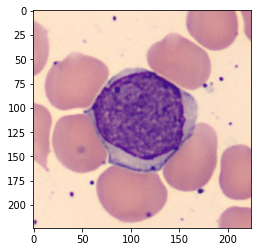

In [14]:
# print image
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

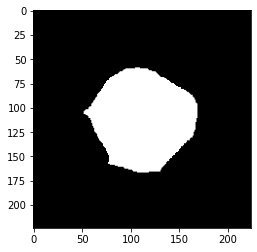

In [15]:
# print mask
gt_mask = batch_y[0]['masks']
plt.imshow(gt_mask.squeeze(), cmap='gray')

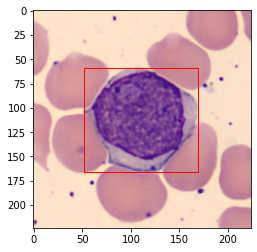

In [16]:
# plot bounding box
bbox = batch_y[0]['boxes'][0]
x1, y1 = bbox[0], bbox[1]
x2, y2 = bbox[2], bbox[3]

plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec="red")
plt.gca().add_patch(rectangle)
plt.show()

### 2. Image Segmentation using Pretrained Mask R-CNN

#### 2.1 Define model architecture

In [17]:
# define model
model = maskrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [18]:
# print model architecture
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [19]:
num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
num_filters = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    num_filters,
                                                    num_classes)

In [20]:
# check forward pass
model.forward??

In [21]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [22]:
output

[{'boxes': tensor([[1.0915e+02, 2.1225e+02, 2.2373e+02, 2.2273e+02],
          [0.0000e+00, 1.9463e+02, 1.8376e+02, 2.1953e+02],
          [3.1666e+01, 3.0681e+01, 4.5011e+01, 5.4551e+01],
          [0.0000e+00, 6.2069e-01, 2.0929e+02, 2.7700e+01],
          [0.0000e+00, 1.0989e-01, 7.6131e+01, 3.2133e+01],
          [7.6743e+01, 1.1987e+02, 1.4426e+02, 1.3959e+02],
          [3.4201e+01, 3.5789e+01, 4.7367e+01, 6.2933e+01],
          [1.0038e+01, 6.1232e+00, 1.5133e+02, 4.7237e+01],
          [2.1876e+02, 5.3375e+01, 2.2400e+02, 9.3569e+01],
          [2.2036e+02, 1.3529e+02, 2.2400e+02, 1.3977e+02],
          [2.1872e+02, 2.2200e+01, 2.2388e+02, 5.8599e+01],
          [0.0000e+00, 1.6857e+02, 1.6548e+02, 2.2047e+02],
          [2.2046e+02, 1.3305e+02, 2.2400e+02, 1.3759e+02],
          [1.4932e+02, 7.8198e+01, 2.1055e+02, 9.8914e+01],
          [9.9547e+01, 1.1853e+02, 1.1649e+02, 1.3510e+02],
          [2.2107e+02, 9.9954e+00, 2.2382e+02, 3.2404e+01],
          [2.2139e+02, 1.3748e+

In [23]:
output[0]['masks'].shape

torch.Size([100, 1, 224, 224])

In [24]:
output[0]['masks'][0].shape

torch.Size([1, 224, 224])

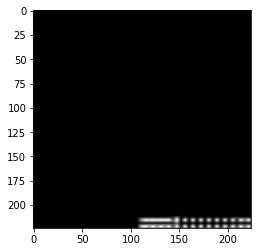

In [25]:
# print output
mask = output[0]['masks'][0].detach().numpy()
plt.imshow(mask.squeeze(), cmap='gray')

#### 2.2 Train the model

In [26]:
# transfer model to GPU
model = model.to("cuda")

In [27]:
# define optimization and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# set model to train
model.train()

# train model
for epoch in range(10):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = list(image.to("cuda") for image in batch_x)
        batch_y = [{k: v.to("cuda") for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss_dict['loss_mask'].item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Training loss for epoch 1 is 0.33251498754207903 
Training loss for epoch 2 is 0.28833765937731815 
Training loss for epoch 3 is 0.24728443530889657 
Training loss for epoch 4 is 0.20787504888497865 
Training loss for epoch 5 is 0.3046596829707806 
Training loss for epoch 6 is 0.20677536267500657 
Training loss for epoch 7 is 0.17726973272286928 
Training loss for epoch 8 is 0.15315725482427156 
Training loss for epoch 9 is 0.13804744814450925 
Training loss for epoch 10 is 0.14331091539217874 


#### 2.3 Calculate IoU score

In [30]:
# get sample data
image = Image.open('/content/images_BloodCellSegmentation/002.bmp')
gt_mask = Image.open('/content/targets_BloodCellSegmentation/002.png')

# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = ((gt_mask == 128) | (gt_mask == 255))
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize(224),
            ToTensor()
            ])
        
image = transform(image)

gt_mask = transform(gt_mask)

In [31]:
# get prediction
model.eval()
output = model(image.unsqueeze(dim=0).to('cuda'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [32]:
# get output mask
output = output[0]['masks'][0].cpu().detach().numpy()

In [33]:
# print shape
output.shape

(1, 224, 224)

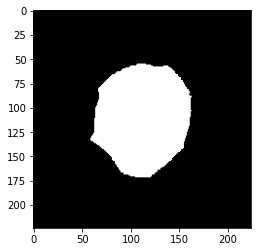

In [34]:
# plot ground truth mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

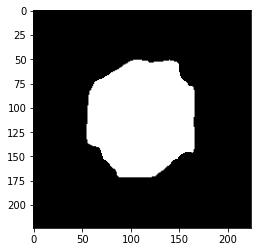

In [35]:
# plot predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [36]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for WBC
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.8421393541223281